In [1]:
import pandas as pd
import os
import numpy as np
from merf import MERF
import matplotlib.pyplot as plt
from merf.viz import plot_merf_training_stats
# Create output directory if it doesn't exist
output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_plots"
os.makedirs(output_dir, exist_ok=True)


def read_data(directory, filename):
    """Read CSV data from specified directory and filename"""
    filepath = os.path.join(directory, filename)
    return pd.read_csv(filepath)

print("---------- Read taxonomy data ---------- ")
t_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/data/taxa/aim2_transformed/"
tax_test = read_data(t_dir, "genus/aim2_clr_testing.csv")
tax_train = read_data(t_dir, "genus/aim2_clr_training.csv") 
tax_full = read_data(t_dir, "genus/clr_taxa_all.csv")

print("---------- Read metadata ----------")
m1_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/data/clinical/transformed/aim2"
test = read_data(m1_dir, "a2_test_samples_standard_clinical.csv")
train = read_data(m1_dir, "a2_train_samples_standard_clinical.csv")
full = read_data(m1_dir, "a2_meta_Transformed_standard_clinical.csv")
full_raw = read_data(m1_dir, "a2_meta_not_Transformed_standard_clinical.csv")

---------- Read taxonomy data ---------- 
---------- Read metadata ----------


In [2]:
# Process Taxa Input data
# FULL dataset
# Split X column into character_id and timepoint
print("---------- Split X column into character_id and timepoint ----------")
tax_full_t = tax_full.copy()
X_LABEL = 'Unnamed: 0'
print(tax_full_t[X_LABEL])

---------- Split X column into character_id and timepoint ----------
0      AAL-144.12m
1       AAL-144.3m
2       AAL-144.6m
3       AAL-144.BL
4       ABR-079.3m
          ...     
590     YSU-097.6m
591     YSU-097.BL
592     ZVU-096.3m
593     ZVU-096.6m
594     ZVU-096.BL
Name: Unnamed: 0, Length: 595, dtype: object


In [3]:
tax_full_t[['character_id', 'timepoint']] = tax_full_t[X_LABEL].str.split('.', expand=True)

In [4]:
# Create time column (assuming create_t_column functionality maps timepoints to numeric values)
def create_t_column(df):
    # Map timepoints to numeric values
    time_map = {'BL': '0', '3m': '3', '6m': '6', '12m': '12', '18m': '18'}
    
    # Check for missing timepoints and raise exception if found
    missing_timepoints = df['timepoint'][~df['timepoint'].isin(time_map.keys())]
    if not missing_timepoints.empty:
        print(f"Error: Found unmapped timepoint(s): {missing_timepoints.unique().tolist()}")
        raise KeyError(f"Timepoint(s) not found in mapping: {missing_timepoints.unique().tolist()}")
        
    return df['timepoint'].map(time_map)

print("---------- Create time column ----------")
tax_full_t['t'] = create_t_column(tax_full_t)

print("---------- Create x_t column combining character_id and t ----------")
tax_full_t['x_t'] = tax_full_t['character_id'] + '.' + tax_full_t['t']

---------- Create time column ----------
---------- Create x_t column combining character_id and t ----------


In [5]:
print("---------- Filter and select columns ----------")
tax = tax_full_t[~tax_full_t['t'].isin(['3', '18'])]
tax = tax.drop(['t', 'timepoint', 'character_id', X_LABEL], axis=1)

---------- Filter and select columns ----------


In [6]:
print("---------- Build training dataset ----------")
train_t = tax_train.copy()
train_t[['character_id', 'timepoint']] = train_t[X_LABEL].str.split('.', expand=True)
train_t['t'] = create_t_column(train_t)
train_t['x_t'] = train_t['character_id'] + '.' + train_t['t']
train_t = train_t[~train_t['t'].isin(['3', '18'])]


---------- Build training dataset ----------


In [7]:
print("---------- Build testing dataset ----------")
test_t = tax_test.copy()
test_t[['character_id', 'timepoint']] = test_t[X_LABEL].str.split('.', expand=True)
test_t['t'] = create_t_column(test_t)
test_t['x_t'] = test_t['character_id'] + '.' + test_t['t']
test_t = test_t[~test_t['t'].isin(['3', '18'])]

---------- Build testing dataset ----------


In [8]:
print("---------- Clean up ----------")
del tax_test, tax_train, tax, tax_full

---------- Clean up ----------


In [9]:
print(full_raw.columns.to_list())
print("---")
print(train.columns.to_list())
print("---")
print(test.columns.to_list())

['Unnamed: 0', 'record_id', 'subject_id', 'randomized_group', 'cohort_number', 'sex', 'race', 'age', 'outcome_BMI_fnl_BL', 'Glucose_BL', 'HOMA_IR_BL', 'Insulin_endo_BL', 'HDL_Total_Direct_lipid_BL', 'LDL_Calculated_BL', 'Triglyceride_lipid_BL', 'outcome_BMI_fnl_6m', 'Glucose_6m', 'HOMA_IR_6m', 'Insulin_endo_6m', 'HDL_Total_Direct_lipid_6m', 'LDL_Calculated_6m', 'Triglyceride_lipid_6m', 'outcome_BMI_fnl_12m', 'Glucose_12m', 'HOMA_IR_12m', 'Insulin_endo_12m', 'HDL_Total_Direct_lipid_12m', 'LDL_Calculated_12m', 'Triglyceride_lipid_12m']
---
['Unnamed: 0', 'record_id', 'subject_id', 'randomized_group', 'cohort_number', 'sex', 'race', 'age', 'outcome_BMI_fnl_BL', 'Glucose_BL', 'HOMA_IR_BL', 'Insulin_endo_BL', 'HDL_Total_Direct_lipid_BL', 'LDL_Calculated_BL', 'Triglyceride_lipid_BL', 'outcome_BMI_fnl_6m', 'Glucose_6m', 'HOMA_IR_6m', 'Insulin_endo_6m', 'HDL_Total_Direct_lipid_6m', 'LDL_Calculated_6m', 'Triglyceride_lipid_6m', 'outcome_BMI_fnl_12m', 'Glucose_12m', 'HOMA_IR_12m', 'Insulin_endo_

In [10]:
print(full_raw.columns.to_list() == train.columns.to_list())
print(train.columns.to_list() == test.columns.to_list())

True
True


In [11]:
import pandas as pd
import re

# Process metadata to long format
def make_long(wide_data):
    """
    Converts a wide-format DataFrame into a long-format DataFrame,
    aligning with the structure produced by the R transformation.
    
    Args:
        wide_data (pd.DataFrame): Input DataFrame in wide format.
    
    Returns:
        pd.DataFrame: Transformed DataFrame in long format.
    """
    # Extract measurement columns and id columns
    id_vars = [col for col in wide_data.columns if not re.search(r'_(BL|6m|12m)$', col)]
    value_vars = [col for col in wide_data.columns if re.search(r'_(BL|6m|12m)$', col)]

    # Melt the DataFrame to long format
    long_data = wide_data.melt(
        id_vars=id_vars,
        value_vars=value_vars,
        var_name="measurement_time",
        value_name="value"
    )

    # Extract measurement type and time from the variable name
    long_data[['measurement_type', 'time']] = long_data['measurement_time'].str.extract(r'(.+)_(BL|6m|12m)')

    # Map time values
    time_mapping = {'BL': 0, '6m': 6, '12m': 12}
    long_data['time'] = long_data['time'].map(time_mapping)

    # Drop the original melted column
    long_data = long_data.drop(columns=['measurement_time'])

    # Pivot the data back to wide format for measurements
    long_data = long_data.pivot_table(
        index=id_vars + ['time'], 
        columns='measurement_type', 
        values='value'
    ).reset_index()

    # Flatten the column MultiIndex from pivot_table
    long_data.columns.name = None
    long_data.columns = [str(col) for col in long_data.columns]

    return long_data


# Apply the function to each meta dataset
print("---------- Convert metadata to long format ----------")
full_long = make_long(full_raw)
full_long['x_t'] = full_long['subject_id'].astype(str) + '.' + full_long['time'].astype(str)

train_long = make_long(train)
train_long['x_t'] = train_long['subject_id'].astype(str) + '.' + train_long['time'].astype(str)

test_long = make_long(test)
test_long['x_t'] = test_long['subject_id'].astype(str) + '.' + test_long['time'].astype(str)

---------- Convert metadata to long format ----------


In [12]:
# Inspect the final column names for test_long
print("outcome_BMI_fnl values:", train_long['outcome_BMI_fnl'])

outcome_BMI_fnl values: 0      0.034462
1     -1.834935
2     -2.100432
3      0.242276
4      0.197886
         ...   
286    0.649937
287    0.846129
288   -0.095905
289   -0.669300
290   -1.201747
Name: outcome_BMI_fnl, Length: 291, dtype: float64


In [13]:
print("Columns after transformation:", full_long.columns.to_list())
print("Columns after transformation:", test_long.columns.to_list())

Columns after transformation: ['Unnamed: 0', 'record_id', 'subject_id', 'randomized_group', 'cohort_number', 'sex', 'race', 'age', 'time', 'Glucose', 'HDL_Total_Direct_lipid', 'HOMA_IR', 'Insulin_endo', 'LDL_Calculated', 'Triglyceride_lipid', 'outcome_BMI_fnl', 'x_t']
Columns after transformation: ['Unnamed: 0', 'record_id', 'subject_id', 'randomized_group', 'cohort_number', 'sex', 'race', 'age', 'time', 'Glucose', 'HDL_Total_Direct_lipid', 'HOMA_IR', 'Insulin_endo', 'LDL_Calculated', 'Triglyceride_lipid', 'outcome_BMI_fnl', 'x_t']


In [14]:
print("---------- Clean up ----------")
#del test, train, full_raw, full

print("---------- Select and prepare metadata for merging ----------")
full_meta = full_long[['x_t', 'outcome_BMI_fnl']]
test_meta = test_long[['x_t', 'outcome_BMI_fnl']]
train_meta = train_long[['x_t', 'outcome_BMI_fnl']]
print("full_meta shape = ", full_meta.shape)

print("---------- Merge training data ----------")
full_train_tax = train_t.merge(full_meta, on='x_t', how='inner')
train_tax = train_t.merge(train_meta, on='x_t')
train_tax = train_tax.drop(['x_t', X_LABEL, 'character_id', 'timepoint'], axis=1)
print("train_tax shape = ", train_tax.shape)
print("full_train_tax shape = ", full_train_tax.shape)

print("---------- Merge testing data ----------")
full_test_tax = test_t.merge(full_meta, on='x_t', how='inner')
test_tax = test_t.merge(test_meta, on='x_t')
test_tax = test_tax.drop(['x_t', X_LABEL, 'character_id', 'timepoint'], axis=1)
print("test_tax shape = ", test_tax.shape)
print("full_test_tax shape = ", full_test_tax.shape)


---------- Clean up ----------
---------- Select and prepare metadata for merging ----------
full_meta shape =  (361, 2)
---------- Merge training data ----------
train_tax shape =  (259, 182)
full_train_tax shape =  (259, 186)
---------- Merge testing data ----------
test_tax shape =  (63, 182)
full_test_tax shape =  (63, 186)


In [15]:
# Inspect the columns of the tax_full_t DataFrame
print(tax_full_t.columns.to_list())

# Perform the merge with custom suffixes to prevent 'X.x' and 'X.y'
print("---------- Merge full dataset ----------")
full = tax_full_t.merge(full_long, on='x_t', how='left', suffixes=('_tax', '_long'))

# Check the columns of the merged DataFrame
print("Columns after merge:", full.columns.to_list())

# Define columns to drop after merge (including Unnamed: 0 if present)
columns_to_drop = ['Unnamed: 0', 'X.y', 'X.x', 'randomized_group', 'cohort_number', 'record_id',
                  'subject_id', 'character_id', 'cohort_number', 'age', 'race', 'sex', 
                  'time', 'timepoint', 'HOMA_IR', 'Insulin_endo', 'HDL_Total_Direct_lipid',
                  'Glucose', 'LDL_Calculated', 'Triglyceride_lipid']

# Drop columns only if they exist in the DataFrame (since some may not be present after merge)
full = full.drop([col for col in columns_to_drop if col in full.columns], axis=1)

# Check the final columns
print("Final columns after drop:", full.columns.to_list())

# Clean up unnecessary variables
print("---------- Clean up ----------")
#del train_meta, test_meta, test_t, train_t, test_long, train_long, full_long, tax_full_t

['Unnamed: 0', 'g__Parabacteroides_B_862066', 'g__Coprenecus', 'g__Butyricimonas', 'g__Odoribacter_865974', 'g__Alistipes_A_871404', 'g__Paramuribaculum', 'g__Alistipes_A_871400', 'g__Barnesiella', 'g__Coprobacter', 'g__Phocaeicola_A_858004', 'g__Bacteroides_H', 'g__Prevotella', 'g__Paraprevotella', 'g__Methanobrevibacter_A', 'g__DTU012', 'g__Escherichia_710834', 'g__Parasutterella', 'g__Sutterella', 'g__Haemophilus_D_735815', 'g__Enterobacter_B_713587', 'g__Akkermansia', 'g__Eubacterium_O_258270', 'g__Anaerofustis', 'g__Peptococcus', 'g__QAMH01', 'g__Senegalimassilia', 'g__Adlercreutzia_404257', 'g__Slackia_A', 'g__Eggerthella', 'g__CAG.1427', 'g__Gordonibacter', 'g__Collinsella', 'g__Holdemania', 'g__Longibaculum', 'g__Catenibacterium', 'g__Erysipelatoclostridium', 'g__Faecalibacillus', 'g___2', 'g__Holdemanella', 'g__Merdibacter', 'g__Clostridium_AQ', 'g__Amedibacillus', 'g__Longicatena', 'g__Dielma', 'g__Pauljensenia', 'g__Bifidobacterium_388775', 'g__Acidaminococcus', 'g__Phascola

In [16]:
print("---------- Remove NAs and filter by time ----------")
full_no_na = full.dropna()

# Get rows where t is NaN and display them
nan_rows = full[full['t'].isna()]
print("\nRows with NaN in 't' column:")
print(nan_rows)
print(f"\nTotal rows with NaN in 't': {len(nan_rows)}")

test_tax_no_na = test_tax.dropna()
train_tax_no_na = train_tax.dropna()
full_train_tax = full_train_tax.dropna()
full_test_tax = full_test_tax.dropna()

print("test_tax_no_na shape = ", test_tax_no_na.shape)
print("train_tax_no_na shape = ", train_tax_no_na.shape)
print("---------- raw train and tax ----------")
print("full_train_tax shape = ", full_train_tax.shape)
print("full_test_tax shape = ", full_test_tax.shape)

print("---------- Create demo datasets filtered by time ----------")
demo_train = full_no_na[full_no_na['t'].astype(int) < 12]
demo_test = full_no_na[full_no_na['t'].astype(int) == 12]
print("demo_test shape = ", demo_test.shape)


---------- Remove NAs and filter by time ----------

Rows with NaN in 't' column:
Empty DataFrame
Columns: [Unnamed: 0_tax, g__Parabacteroides_B_862066, g__Coprenecus, g__Butyricimonas, g__Odoribacter_865974, g__Alistipes_A_871404, g__Paramuribaculum, g__Alistipes_A_871400, g__Barnesiella, g__Coprobacter, g__Phocaeicola_A_858004, g__Bacteroides_H, g__Prevotella, g__Paraprevotella, g__Methanobrevibacter_A, g__DTU012, g__Escherichia_710834, g__Parasutterella, g__Sutterella, g__Haemophilus_D_735815, g__Enterobacter_B_713587, g__Akkermansia, g__Eubacterium_O_258270, g__Anaerofustis, g__Peptococcus, g__QAMH01, g__Senegalimassilia, g__Adlercreutzia_404257, g__Slackia_A, g__Eggerthella, g__CAG.1427, g__Gordonibacter, g__Collinsella, g__Holdemania, g__Longibaculum, g__Catenibacterium, g__Erysipelatoclostridium, g__Faecalibacillus, g___2, g__Holdemanella, g__Merdibacter, g__Clostridium_AQ, g__Amedibacillus, g__Longicatena, g__Dielma, g__Pauljensenia, g__Bifidobacterium_388775, g__Acidaminococcu

Make train set

In [17]:
print("---------- Select predictors for training set ----------")
train_set = full_train_tax
X = train_set.drop(['t', 'outcome_BMI_fnl', 'all_samples'], axis=1)
X = X.drop(columns=['Unnamed: 0_tax', 'x_t'], errors='ignore')
Y = train_set[['outcome_BMI_fnl']]
Y = Y['outcome_BMI_fnl'].to_numpy() # Convert Y to numeric array
clusters_train = train_set['all_samples'].to_numpy() # Get ID variables
Z = np.ones((train_set.shape[0], 1)) # Create random effects matrix with ones
time = train_set['t'].astype(float).to_numpy() # Get time values as numeric array 

---------- Select predictors for training set ----------


Make test set

In [18]:
print("---------- Select predictors for test set ----------")
test_set = full_test_tax
X_new = test_set.drop(['t', 'outcome_BMI_fnl', 'all_samples'], axis=1)
# Drop any unwanted columns and align test set features with training features
X_new = test_set.drop(['t', 'outcome_BMI_fnl', 'all_samples'], axis=1)  # Drop non-predictor columns
X_new = X_new[X.columns]  # Reorder and select columns to match training set
X_new = X_new.astype(X.dtypes)  # Ensure data types match
X_new = X_new.drop(columns=['Unnamed: 0_tax', 'x_t'], errors='ignore')
X_new = X_new.drop(columns=['Unnamed: 0', 'character_id', 'timepoint'], errors='ignore')


Y_new = test_set['outcome_BMI_fnl'].to_numpy()  # Convert Y to numeric array
clusters_new = pd.Series(test_set['all_samples'])  # Convert to pandas Series
# Create random effects matrix with ones
Z_new = np.ones((len(X_new), 1))
time_new = test_set['t'].astype(float).to_numpy()  # Convert time values to numeric array

---------- Select predictors for test set ----------


In [19]:
print("---------- RUN MERF 🥰 ----------")
# Mixed Effects Random Forest Training
mrf = MERF()
mrf.fit(X.select_dtypes(include=[np.number]), Z, pd.Series(clusters_train), Y)
 # Mixed Effects Random Forest Training with participant RE

---------- RUN MERF 🥰 ----------


INFO     [merf.py:307] Training GLL is 240.79834700087196 at iteration 1.
INFO     [merf.py:307] Training GLL is 312.4931677555111 at iteration 2.
INFO     [merf.py:307] Training GLL is 320.5619328148336 at iteration 3.
INFO     [merf.py:307] Training GLL is 319.73880796369406 at iteration 4.
INFO     [merf.py:307] Training GLL is 331.874541682312 at iteration 5.
INFO     [merf.py:307] Training GLL is 330.5596500287716 at iteration 6.
INFO     [merf.py:307] Training GLL is 335.0190064733472 at iteration 7.
INFO     [merf.py:307] Training GLL is 340.35187827726884 at iteration 8.
INFO     [merf.py:307] Training GLL is 337.74467005693396 at iteration 9.
INFO     [merf.py:307] Training GLL is 352.39266950408717 at iteration 10.
INFO     [merf.py:307] Training GLL is 353.750541433746 at iteration 11.
INFO     [merf.py:307] Training GLL is 349.1389849892698 at iteration 12.
INFO     [merf.py:307] Training GLL is 346.64044759725255 at iteration 13.
INFO     [merf.py:307] Training GLL is 346.

In [20]:
print(dir(mrf))

['D_hat_history', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__firstlineno__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__static_attributes__', '__str__', '__subclasshook__', '__weakref__', 'b_hat_history', 'cluster_counts', 'fe_model', 'fit', 'get_bhat_history_df', 'gll_early_stop_threshold', 'gll_history', 'max_iterations', 'predict', 'score', 'sigma2_hat_history', 'trained_b', 'trained_fe_model', 'val_loss_history']


In [ ]:
plot_merf_training_stats(mrf, num_clusters_to_plot=100)

Once fit, the model can be used to predict on new samples given X, Z, and id's. The predict code handles whether or not to apply the random effect correction based on if the id of the new sample was seen in training or not.

In [21]:
# Make sure training and testing match up 
print("Columns in training set:", X.columns)
print("Columns in test set:", X_new.columns)
print("---------- no diff ----------")
print(set(X.columns) - set(X_new.columns))  # Columns in training but not test
print(set(X_new.columns) - set(X.columns))  # Columns in test but not training
print("---------- Train data types ----------")
print(X.dtypes)  # Data types of training set
print("---------- Test data types ----------")
print(X_new.dtypes)

Columns in training set: Index(['Unnamed: 0', 'g__Parabacteroides_B_862066', 'g__Coprenecus',
       'g__Butyricimonas', 'g__Odoribacter_865974', 'g__Alistipes_A_871404',
       'g__Paramuribaculum', 'g__Alistipes_A_871400', 'g__Barnesiella',
       'g__Coprobacter',
       ...
       'g__Ventrisoma', 'g__Clostridium_Q_135853', 'g__Clostridium_Q_135822',
       'g__Porcincola', 'g__Copromonas', 'g__Ventrimonas', 'g__Dorea_A',
       'g__Massilistercora', 'character_id', 'timepoint'],
      dtype='object', length=182)
Columns in test set: Index(['g__Parabacteroides_B_862066', 'g__Coprenecus', 'g__Butyricimonas',
       'g__Odoribacter_865974', 'g__Alistipes_A_871404', 'g__Paramuribaculum',
       'g__Alistipes_A_871400', 'g__Barnesiella', 'g__Coprobacter',
       'g__Phocaeicola_A_858004',
       ...
       'g__Lactonifactor', 'g__Enterocloster', 'g__Ventrisoma',
       'g__Clostridium_Q_135853', 'g__Clostridium_Q_135822', 'g__Porcincola',
       'g__Copromonas', 'g__Ventrimonas', 'g__D

In [22]:
print(X.iloc[:, 0])
print("X_new shape:", X_new.shape)
print("Z_new shape:", Z_new.shape) 
print("clusters_new shape:", clusters_new.shape)


0      ACO-053.12m
1       ACO-053.6m
2       ACO-053.BL
3       ADA-105.BL
4      AGA-071.12m
          ...     
254     YOR-103.6m
255     YOR-103.BL
256    YSU-097.12m
257     YSU-097.6m
258     YSU-097.BL
Name: Unnamed: 0, Length: 259, dtype: object
X_new shape: (63, 179)
Z_new shape: (63, 1)
clusters_new shape: (63,)


In [23]:
# Predict using the fitted model
y_hat_new = mrf.predict(X_new, Z_new, clusters_new)
print(y_hat_new)

[31.50598148 31.57570777 32.03119247 31.85680534 31.44589297 31.23700317
 31.65929516 31.97890133 31.20753869 32.25689831 32.63070177 32.26621414
 32.43027061 31.16979421 32.54876621 33.12989313 32.74501348 32.27184133
 33.34735428 32.19229541 32.25837489 32.906694   32.85235152 32.49334301
 32.37818438 31.61454898 32.62695119 31.48966072 31.96301241 32.2975165
 31.95511618 31.95516708 32.36415419 33.15462343 31.62530583 32.23394136
 32.20036146 32.1126885  32.85344607 32.53836288 33.46052323 32.73949988
 31.97266149 31.25142097 31.82068592 32.13557324 32.22742794 32.27642141
 32.4087797  31.93858143 33.65609115 32.78413829 33.06565443 33.8891173
 31.59929174 31.26493294 30.91670051 31.76957978 31.31240959 31.56717785
 33.41741306 32.47461304 31.9332199 ]


Look up longitudinal R - squared values 

In [24]:
# Calculate and print RMSE and R-squared
rmse = np.sqrt(np.mean((Y_new - y_hat_new)**2))
correlation = np.corrcoef(Y_new, y_hat_new)[0,1]
print(f"Correlation between actual and predicted values: {correlation:.4f}")
r2 = 1 - (np.sum((Y_new - y_hat_new)**2) / np.sum((Y_new - np.mean(Y_new))**2))
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R-squared Score: {r2:.4f}")

Correlation between actual and predicted values: 0.2186
Root Mean Squared Error: 5.0846
R-squared Score: -0.0509


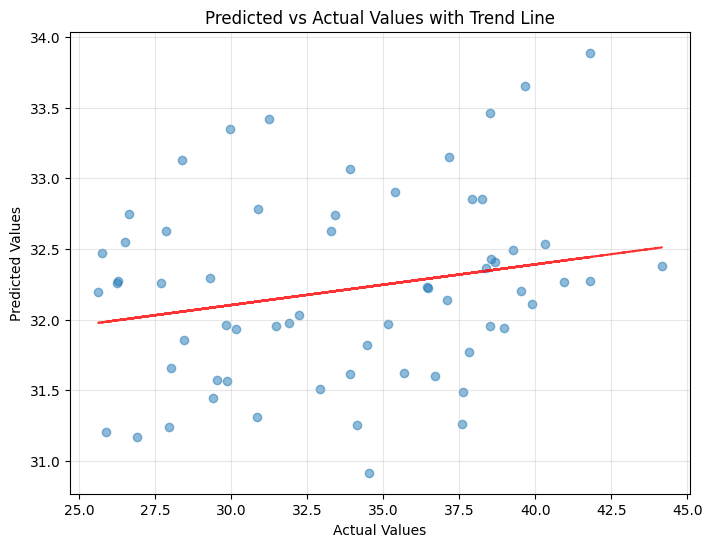

In [25]:
# Create scatter plot of predicted vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(Y_new, y_hat_new, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values with Trend Line')

# Add trend line
z = np.polyfit(Y_new, y_hat_new, 1)
p = np.poly1d(z)
plt.plot(Y_new, p(Y_new), "r--", alpha=0.8)
plt.grid(True, alpha=0.3)

# Save plot as PNG and PDF
plt.savefig(os.path.join(output_dir, 'predicted_vs_actual.png'), dpi=300, bbox_inches='tight')
plt.show()